In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import boto3

# Initialize S3 
s3 = boto3.client('s3')

# S3 paths 
bucket_name = 'nexttrendco'
train_path = 'walmart/train.csv'
val_path = 'walmart/val.csv'
test_path = 'walmart/test.csv'

# Load preprocessed data from S3
train_walmart = pd.read_csv(f's3://{bucket_name}/{train_path}')
val_walmart = pd.read_csv(f's3://{bucket_name}/{val_path}')
test_walmart = pd.read_csv(f's3://{bucket_name}/{test_path}')

# Preprocess training data
train_walmart = train_walmart.drop(columns=['Date'], errors='ignore')
train_walmart['lag_1'] = train_walmart['Weekly_Sales'].shift(1)
train_walmart['lag_7'] = train_walmart['Weekly_Sales'].shift(7)
train_walmart['rolling_mean_7'] = train_walmart['Weekly_Sales'].rolling(window=7).mean()
train_walmart.dropna(inplace=True)

# Preprocess validation data
val_walmart = val_walmart.drop(columns=['Date'], errors='ignore')
val_walmart['lag_1'] = val_walmart['Weekly_Sales'].shift(1)
val_walmart['lag_7'] = val_walmart['Weekly_Sales'].shift(7)
val_walmart['rolling_mean_7'] = val_walmart['Weekly_Sales'].rolling(window=7).mean()
val_walmart.dropna(inplace=True)

# Check data is loaded
print("Train Walmart DataFrame:")
print(train_walmart.head())

print("\nValidation Walmart DataFrame:")
print(val_walmart.head())

print("\nTest Walmart DataFrame:")
print(test_walmart.head())

Train Walmart DataFrame:
    Store  Dept  Weekly_Sales  IsHoliday     lag_1     lag_7  rolling_mean_7
7       1     1      26229.21      False  22136.64  24924.50    28325.102857
8       1     1      57258.43      False  26229.21  46039.49    29927.808571
9       1     1      42960.91      False  57258.43  41595.55    30122.860000
10      1     1      17596.96      False  42960.91  19403.54    29864.777143
11      1     1      16145.35      False  17596.96  21827.90    29052.984286

Validation Walmart DataFrame:
    Store  Dept  Weekly_Sales  IsHoliday     lag_1     lag_7  rolling_mean_7  \
7       1     1      26978.34      False  19354.23  21043.39    18129.977143   
8       1     1      25543.04      False  26978.34  17413.94    19291.277143   
9       1     1      22517.56      False  25543.04  14773.04    20397.637143   
10      1     1      44912.86      False  22517.56  16637.62    24436.957143   
11      1     1      19124.58       True  44912.86  16216.27    24852.430000   

 

In [5]:
# Prepare features and target for training
X_train_walmart = train_walmart.drop(columns=['Weekly_Sales'])
y_train_walmart = train_walmart['Weekly_Sales']

# Prepare features and target for validation
X_val_walmart = val_walmart.drop(columns=['Weekly_Sales'])
y_val_walmart = val_walmart['Weekly_Sales']

# Drop any columns in validation data that don't exist in the training data
X_val_walmart = X_val_walmart[X_train_walmart.columns]

# If there are missing columns in the validation data, add a default value
missing_cols = set(X_train_walmart.columns) - set(X_val_walmart.columns)
for col in missing_cols:
    X_val_walmart[col] = 0

In [6]:
# Create and train the model
xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xg_model.fit(X_train_walmart, y_train_walmart)

# Predict on validation data
y_val_pred = xg_model.predict(X_val_walmart)

# Evaluate model on validation data
mae = mean_absolute_error(y_val_walmart, y_val_pred)
rmse = mean_squared_error(y_val_walmart, y_val_pred, squared=False)

print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Validation MAE: 2970.065930283195
Validation RMSE: 7316.089104793162


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# Prepare test data 
X_test_walmart = test_walmart.drop(columns=['Date'], errors='ignore')
X_test_walmart = X_test_walmart.reindex(columns=X_train_walmart.columns, fill_value=0)

# Predict on  test data
y_test_pred = xg_model.predict(X_test_walmart)

# Display the first 5 predictions 
print(f"First 5 Predictions on Test Data: {y_test_pred[:5]}")

First 5 Predictions on Test Data: [3714.1494 3714.1494 3714.1494 3880.3455 3714.1494]


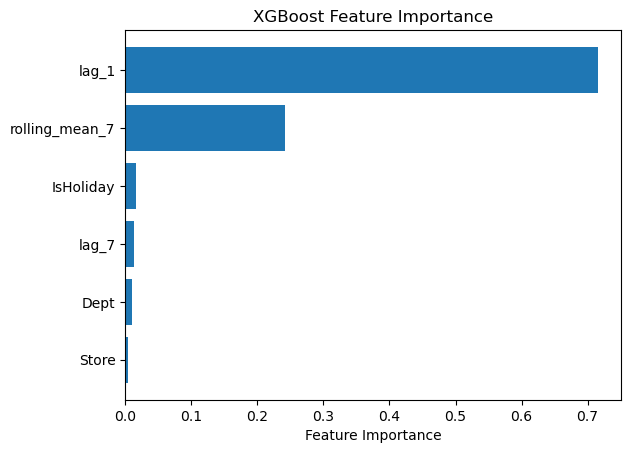

In [8]:
# Plot feature importance
importances = xg_model.feature_importances_
feature_names = X_train_walmart.columns

# Sort the feature importances
sorted_idx = importances.argsort()

plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

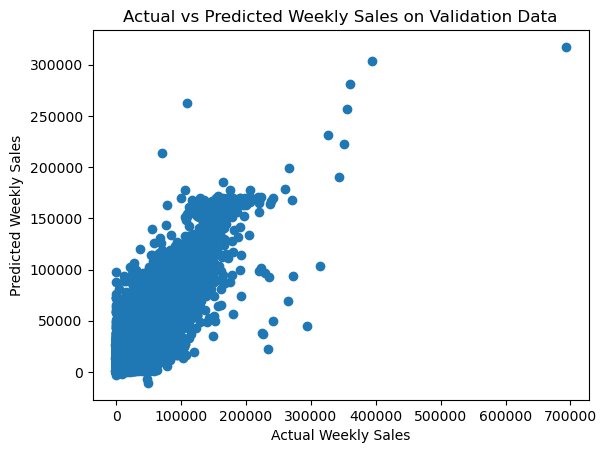

In [9]:
# Plot actual vs predicted for validation data
plt.scatter(y_val_walmart, y_val_pred)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales on Validation Data')
plt.show()

In [15]:
# Save trained model
xg_model.save_model("xgboost_model.bst")

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:52:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [16]:
import tarfile

with tarfile.open("walmart-model.tar.gz", "w:gz") as tar:
    tar.add("xgboost_model.bst")

In [18]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'nexttrendco'
s3_model_path = 'models/walmart-model.tar.gz'

s3.upload_file("walmart-model.tar.gz", bucket_name, s3_model_path)
print("Walmart model uploaded to S3")

Walmart model uploaded to S3


In [24]:
expected_features = ['Store', 'Dept', 'IsHoliday', 'lag_1', 'lag_7', 'rolling_mean_7']

# Add missing features with 0
for col in expected_features:
    if col not in test.columns:
        test[col] = 0

# Reorder columns to match training
test = test[expected_features]

# Predict
preds = xg_model.predict(test)

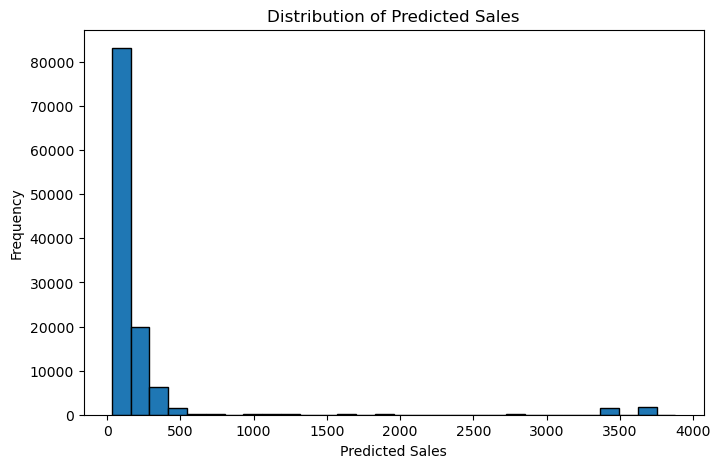

In [26]:
pred_df = pd.DataFrame(preds, columns=["predicted"])

plt.figure(figsize=(8, 5))
plt.hist(pred_df["predicted"], bins=30, edgecolor='black')
plt.title("Distribution of Predicted Sales")
plt.xlabel("Predicted Sales")
plt.ylabel("Frequency")
plt.show()

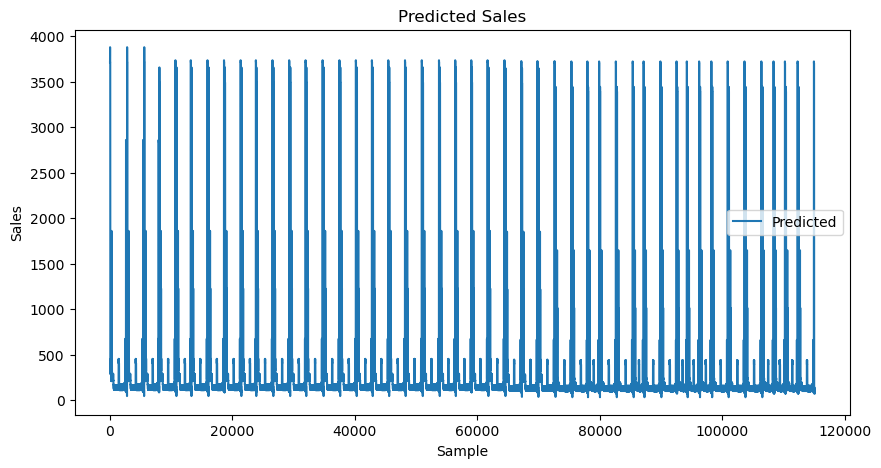

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(preds, label="Predicted")
plt.title("Predicted Sales")
plt.xlabel("Sample")
plt.ylabel("Sales")
plt.legend()
plt.show()